What This Code Does:
Optimizes 10-asset portfolios

Objective 1: Maximize Expected Return

Objective 2: Minimize Portfolio Volatility (Risk)

Uses Pareto front for selection

Enforces constraints: BTCUSD ≤ 10%, USDINR ≤ 5%, and weights sum to 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load your dataset
file_path = '/content/Expanded_AssetData_Equity_Bonds_Currency.csv'  # Update if needed
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Assets and constraints
target_tickers = ['AAPL', 'MSFT', 'JPM', 'GOOG', 'KO', 'GLD', 'TLT', 'BTCUSD', 'USDINR', 'SPY']
max_allocs = {'BTCUSD': 0.10, 'USDINR': 0.05}
n_assets = len(target_tickers)

In [ ]:
# Clean data and compute returns
df = df[df['Ticker'].isin(target_tickers)]
pivot_df = df.pivot(index='Date', columns='Ticker', values='Close').sort_index().dropna()
returns_df = pivot_df.pct_change().dropna()
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

In [ ]:
# 🎯 Objective Functions
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


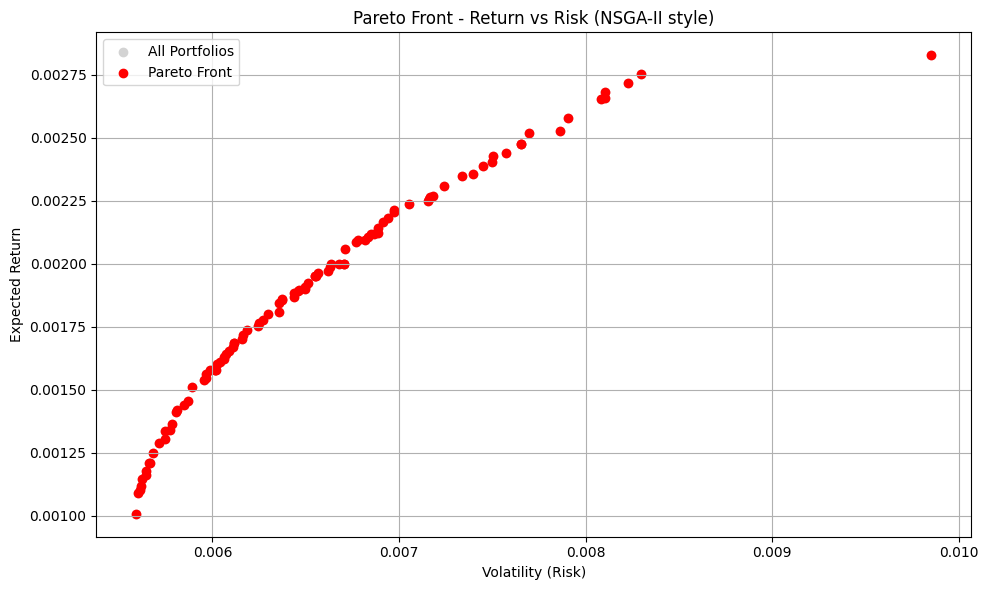

✅ Pareto optimal portfolios generated!


,AAPL,MSFT,JPM,GOOG,KO,GLD,TLT,BTCUSD,USDINR,SPY,Expected_Return,Volatility
0,0.0859,0.1662,0.0565,0.1179,0.2427,0.0708,0.0226,0.1000,0.0266,0.1108,0.0016,0.0060
1,0.1070,0.1768,0.0652,0.1157,0.2872,0.0404,0.0000,0.1000,0.0000,0.1077,0.0019,0.0064
2,0.0811,0.1644,0.0533,0.1113,0.3727,0.0454,0.0000,0.1000,0.0252,0.0467,0.0023,0.0072
3,0.1026,0.1858,0.0653,0.1023,0.3113,0.0388,0.0000,0.0983,0.0215,0.0741,0.0020,0.0066
4,0.0959,0.1718,0.0600,0.0944,0.3130,0.0549,0.0000,0.1000,0.0219,0.0881,0.0020,0.0065


In [ ]:
# 🔁 NSGA-II Style Pareto Sorting
def fast_non_dominated_sort(values1, values2):
    S = [[] for _ in range(len(values1))]
    front = [[]]
    n = [0 for _ in range(len(values1))]
    rank = [0 for _ in range(len(values1))]

    for p in range(len(values1)):
        S[p] = []
        n[p] = 0
        for q in range(len(values1)):
            if (values1[p] >= values1[q] and values2[p] <= values2[q]) and (values1[p] > values1[q] or values2[p] < values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] >= values1[p] and values2[q] <= values2[p]) and (values1[q] > values1[p] or values2[q] < values2[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
              front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i += 1
        front.append(Q)

    del front[-1]
    return front

# ⚖️ Constraints
def normalize_with_constraints(weights, max_allocs=max_allocs, tickers=target_tickers):
    weights = np.maximum(weights, 0)
    weights /= weights.sum()
    for asset, max_val in max_allocs.items():
        idx = tickers.index(asset)
        if weights[idx] > max_val:
            excess = weights[idx] - max_val
            weights[idx] = max_val
            redistribute_idx = [i for i in range(len(weights)) if i != idx]
            redistribute = weights[redistribute_idx]
            redistribute += excess * (redistribute / redistribute.sum())
            for i, j in enumerate(redistribute_idx):
                weights[j] = redistribute[i]
    return weights / np.sum(weights)

# 🧬 Crossover and Mutation
def crossover(p1, p2):
    mask = np.random.randint(0, 2, size=len(p1)).astype(bool)
    return np.where(mask, p1, p2)

def mutate(weights, rate=0.1):
    for i in range(len(weights)):
        if np.random.rand() < rate:
            weights[i] += np.random.normal(0, 0.05)
    return weights

# 🔁 Generate Population
def generate_population(n, asset_count, max_allocs):
    population = []
    for _ in range(n):
        weights = np.random.rand(asset_count)
        weights /= weights.sum()
        weights = normalize_with_constraints(weights)
        population.append(weights)
    return np.array(population)

# EA Settings
population_size = 100
generations = 50

# 🔁 MOEA Loop
population = generate_population(population_size, n_assets, max_allocs)

for gen in range(generations):
    returns = [portfolio_return(w, mean_returns) for w in population]
    risks = [portfolio_volatility(w, cov_matrix) for w in population]

    fronts = fast_non_dominated_sort(returns, risks)
    elite_indices = fronts[0]
    elites = population[elite_indices]
    new_population = elites.tolist()

    while len(new_population) < population_size:
        p1, p2 = elites[np.random.randint(0, len(elites))], elites[np.random.randint(0, len(elites))]
        child = crossover(p1, p2)
        child = mutate(child)
        child = normalize_with_constraints(child)
        new_population.append(child)

    population = np.array(new_population)

# 🎯 Final Evaluation
final_returns = [portfolio_return(w, mean_returns) for w in population]
final_risks = [portfolio_volatility(w, cov_matrix) for w in population]
final_fronts = fast_non_dominated_sort(final_returns, final_risks)
pareto_indices = final_fronts[0]

# 📈 Plot Pareto Front
plt.figure(figsize=(10, 6))
plt.scatter(final_risks, final_returns, c='lightgray', label='All Portfolios')
plt.scatter([final_risks[i] for i in pareto_indices], [final_returns[i] for i in pareto_indices],
            c='red', label='Pareto Front')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Pareto Front - Return vs Risk (NSGA-II style)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🏆 Export Pareto Optimal Portfolios
pareto_portfolios = population[pareto_indices]
pareto_data = pd.DataFrame(pareto_portfolios, columns=target_tickers)
pareto_data['Expected_Return'] = [final_returns[i] for i in pareto_indices]
pareto_data['Volatility'] = [final_risks[i] for i in pareto_indices]
pareto_data = pareto_data.round(4)

# Save to CSV if needed
pareto_data.to_csv('/content/Pareto_Optimal_Portfolios.csv', index=False)

# Display
print("✅ Pareto optimal portfolios generated!")
pareto_data.head()





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [ ]:
# 🧠 Helper: Find the knee point from Pareto front
def find_knee(x, y):
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    line = np.array([x_norm[-1] - x_norm[0], y_norm[-1] - y_norm[0]])
    line /= np.linalg.norm(line)
    vectors = np.vstack((x_norm - x_norm[0], y_norm - y_norm[0])).T
    distances = np.abs(np.cross(line, vectors))
    return np.argmax(distances)

In [ ]:
# ✅ 1. Extract Pareto front return-risk values
pareto_returns = [final_returns[i] for i in pareto_indices]
pareto_risks = [final_risks[i] for i in pareto_indices]

In [ ]:
# ✅ 2. Find knee point index
knee_idx_in_pareto = find_knee(np.array(pareto_risks), np.array(pareto_returns))
knee_portfolio_idx = pareto_indices[knee_idx_in_pareto]
knee_portfolio_weights = population[knee_portfolio_idx]

/tmp/ipython-input-16-2952609528.py:8: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distances = np.abs(np.cross(line, vectors))


In [ ]:
# ✅ 3. Compute daily returns using returns_df (already loaded from your MOEA dataset)
knee_returns = returns_df.dot(knee_portfolio_weights)


In [ ]:
# ✅ 4. Cumulative returns (base = 1.0)
knee_cumulative = (1 + knee_returns).cumprod()
knee_cumulative.index = returns_df.index

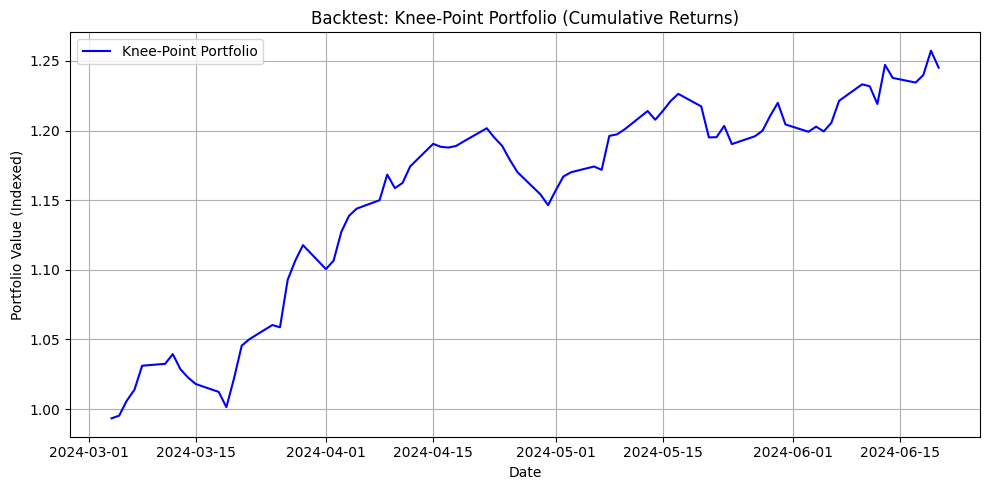

In [ ]:
# ✅ 5. Plot cumulative return
plt.figure(figsize=(10, 5))
plt.plot(knee_cumulative.index, knee_cumulative.values, label="Knee-Point Portfolio", color='blue')
plt.title("Backtest: Knee-Point Portfolio (Cumulative Returns)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Indexed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ✅ 6. Export as CSV
backtest_df = pd.DataFrame({
    'Date': knee_cumulative.index,
    'Portfolio_Value': knee_cumulative.values,
    'Daily_Return': knee_returns.values
}).reset_index(drop=True)

backtest_df.to_csv('/content/Knee_Point_Backtest.csv', index=False)
print("📤 Exported to: /content/Knee_Point_Backtest.csv")

# ✅ 7. Show preview
backtest_df.head()

📤 Exported to: /content/Knee_Point_Backtest.csv


,Date,Portfolio_Value,Daily_Return
0,2024-03-04,0.993361,-0.006639
1,2024-03-05,0.995288,0.001939
2,2024-03-06,1.006103,0.010866
3,2024-03-07,1.013963,0.007812
4,2024-03-08,1.031145,0.016945


#Backtest: SPY vs Knee-Point Portfolio

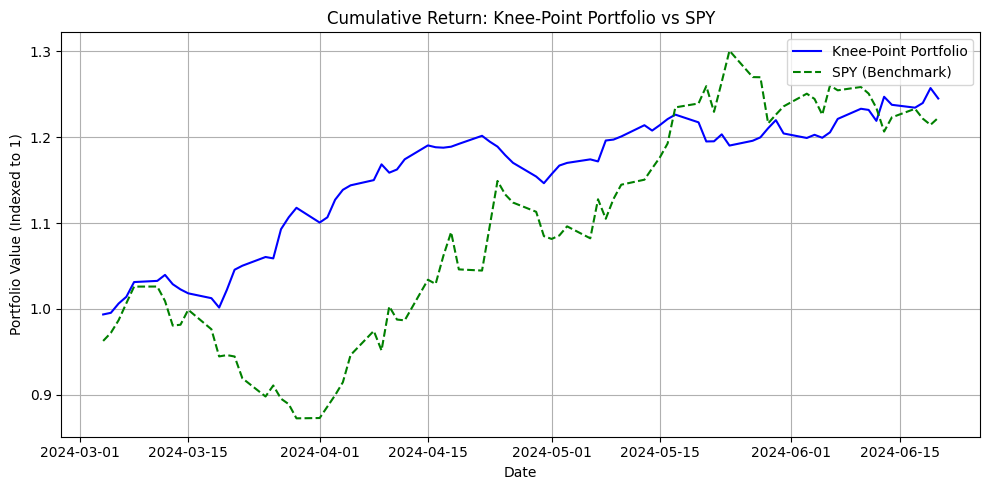

📊 Performance Metrics:
                Sharpe Ratio  Max Drawdown  Volatility
Knee Portfolio        0.2847       -0.0460      0.0099
SPY Benchmark         0.1266       -0.1498      0.0218


<Figure size 800x500 with 0 Axes>

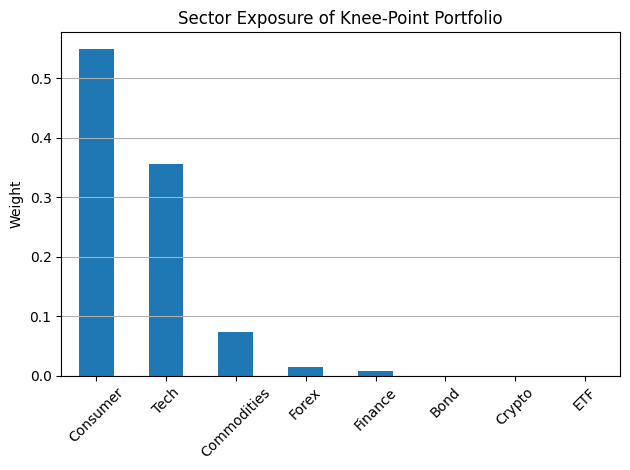

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 1. Ensure SPY is present in returns_df
if 'SPY' not in returns_df.columns:
    raise ValueError("SPY not found in returns_df. Ensure it's part of your dataset.")

# ✅ 2. Calculate daily & cumulative returns
spy_returns = returns_df['SPY']
spy_cumulative = (1 + spy_returns).cumprod()
knee_returns = returns_df.dot(knee_portfolio_weights)
knee_cumulative = (1 + knee_returns).cumprod()

# ✅ 3. Plot cumulative comparison
plt.figure(figsize=(10, 5))
plt.plot(knee_cumulative.index, knee_cumulative.values, label="Knee-Point Portfolio", color='blue')
plt.plot(spy_cumulative.index, spy_cumulative.values, label="SPY (Benchmark)", color='green', linestyle='--')
plt.title("Cumulative Return: Knee-Point Portfolio vs SPY")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Indexed to 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 4. Performance Metrics Function
def calculate_metrics(returns, risk_free_rate=0.01/252):
    excess_returns = returns - risk_free_rate
    sharpe = np.mean(excess_returns) / np.std(excess_returns)
    drawdown = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()) - 1
    max_drawdown = drawdown.min()
    volatility = returns.std()
    return {
        "Sharpe Ratio": round(sharpe, 4),
        "Max Drawdown": round(max_drawdown, 4),
        "Volatility": round(volatility, 4)
    }

# ✅ 5. Calculate metrics
knee_metrics = calculate_metrics(knee_returns)
spy_metrics = calculate_metrics(spy_returns)

performance_df = pd.DataFrame([knee_metrics, spy_metrics], index=["Knee Portfolio", "SPY Benchmark"])
print("📊 Performance Metrics:")
print(performance_df)

# ✅ 6. Sector Exposure
sector_map = {
    'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOG': 'Tech',
    'JPM': 'Finance',
    'KO': 'Consumer',
    'GLD': 'Commodities',
    'TLT': 'Bond',
    'SPY': 'ETF',
    'BTCUSD': 'Crypto',
    'USDINR': 'Forex'
}

sector_weights = {}
for weight, ticker in zip(knee_portfolio_weights, target_tickers):
    sector = sector_map.get(ticker, 'Other')
    sector_weights[sector] = sector_weights.get(sector, 0) + weight

sector_df = pd.DataFrame.from_dict(sector_weights, orient='index', columns=['Weight'])
sector_df = sector_df.sort_values('Weight', ascending=False)

# ✅ 7. Plot Sector Exposure
plt.figure(figsize=(8, 5))
sector_df.plot(kind='bar', legend=False)
plt.title("Sector Exposure of Knee-Point Portfolio")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


#Top 3 Pareto Portfolio Analysis

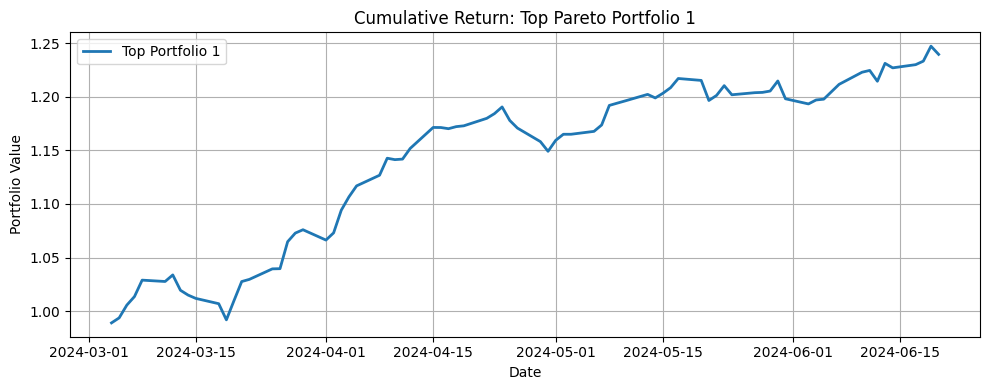

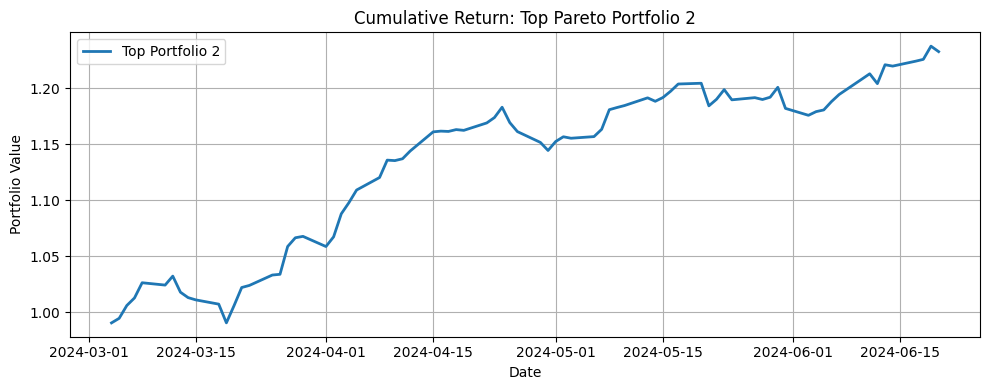

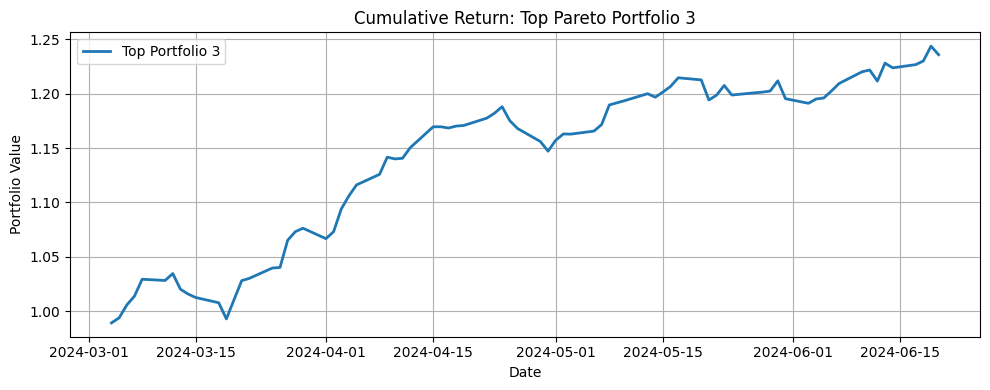

📊 Top 3 Portfolio Performance Metrics:
                 Sharpe Ratio  Max Drawdown  Volatility
Top Portfolio 1        0.3293       -0.0405      0.0083
Top Portfolio 2        0.3282       -0.0404      0.0081
Top Portfolio 3        0.3276       -0.0403      0.0082


<Figure size 700x400 with 0 Axes>

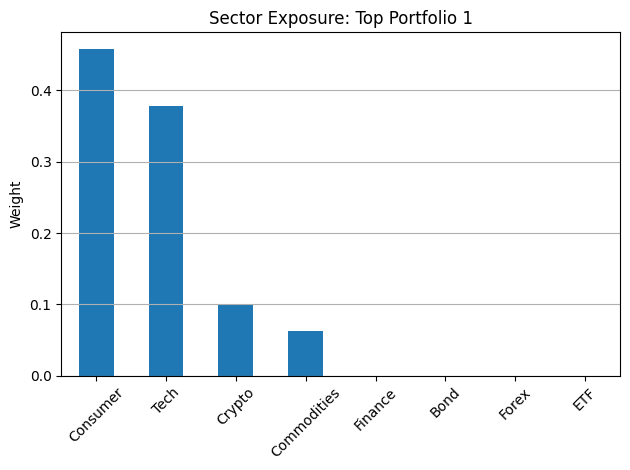

<Figure size 700x400 with 0 Axes>

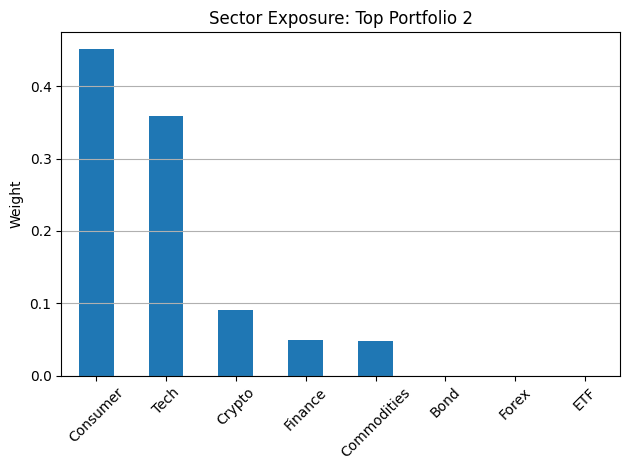

<Figure size 700x400 with 0 Axes>

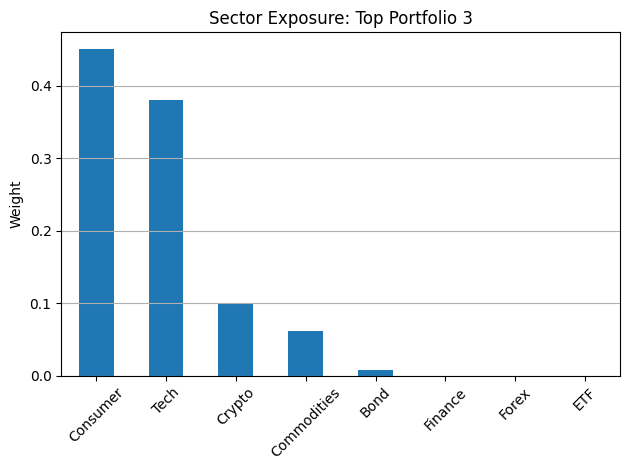

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ⚖️ Sharpe ratio calculation for ranking
sharpe_scores = np.array(final_returns) / np.array(final_risks)

# 🎯 Get top 3 Pareto portfolio indices by Sharpe ratio
top_pareto_indices = sorted(pareto_indices, key=lambda i: sharpe_scores[i], reverse=True)[:3]

top3_metrics = []
top3_sector_data = []

# 📊 Analyze each top portfolio
for i, idx in enumerate(top_pareto_indices):
    weights = population[idx]
    returns = returns_df.dot(weights)
    cumulative = (1 + returns).cumprod()

    # ✅ Performance metrics
    def calculate_metrics(returns, risk_free_rate=0.01/252):
        excess_returns = returns - risk_free_rate
        sharpe = np.mean(excess_returns) / np.std(excess_returns)
        drawdown = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()) - 1
        max_drawdown = drawdown.min()
        volatility = returns.std()
        return {
            "Sharpe Ratio": round(sharpe, 4),
            "Max Drawdown": round(max_drawdown, 4),
            "Volatility": round(volatility, 4)
        }

    metrics = calculate_metrics(returns)
    top3_metrics.append(metrics)

    # ✅ Sector exposure
    sector_map = {
        'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOG': 'Tech',
        'JPM': 'Finance',
        'KO': 'Consumer',
        'GLD': 'Commodities',
        'TLT': 'Bond',
        'SPY': 'ETF',
        'BTCUSD': 'Crypto',
        'USDINR': 'Forex'
    }
    sector_weights = {}
    for weight, ticker in zip(weights, target_tickers):
        sector = sector_map.get(ticker, 'Other')
        sector_weights[sector] = sector_weights.get(sector, 0) + weight
    top3_sector_data.append(sector_weights)

    # 📈 Plot cumulative return
    plt.figure(figsize=(10, 4))
    plt.plot(cumulative.index, cumulative.values, label=f"Top Portfolio {i+1}", linewidth=2)
    plt.title(f"Cumulative Return: Top Pareto Portfolio {i+1}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 📊 Metrics table
top3_df = pd.DataFrame(top3_metrics, index=[f"Top Portfolio {i+1}" for i in range(3)])
print("📊 Top 3 Portfolio Performance Metrics:")
print(top3_df)

# 📈 Sector exposure charts
for i, sector_data in enumerate(top3_sector_data):
    df = pd.DataFrame.from_dict(sector_data, orient='index', columns=['Weight']).sort_values('Weight', ascending=False)
    plt.figure(figsize=(7, 4))
    df.plot(kind='bar', legend=False)
    plt.title(f"Sector Exposure: Top Portfolio {i+1}")
    plt.ylabel("Weight")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


#Advanced Evaluation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

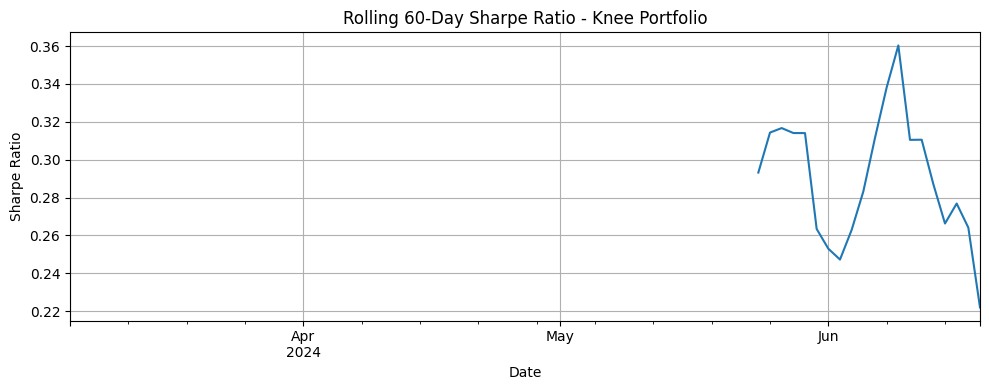

In [ ]:
# 📉 1. Rolling Sharpe Ratio (60-day window)
rolling_sharpe = knee_returns.rolling(window=60).mean() / knee_returns.rolling(window=60).std()
plt.figure(figsize=(10, 4))
rolling_sharpe.plot()
plt.title("Rolling 60-Day Sharpe Ratio - Knee Portfolio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

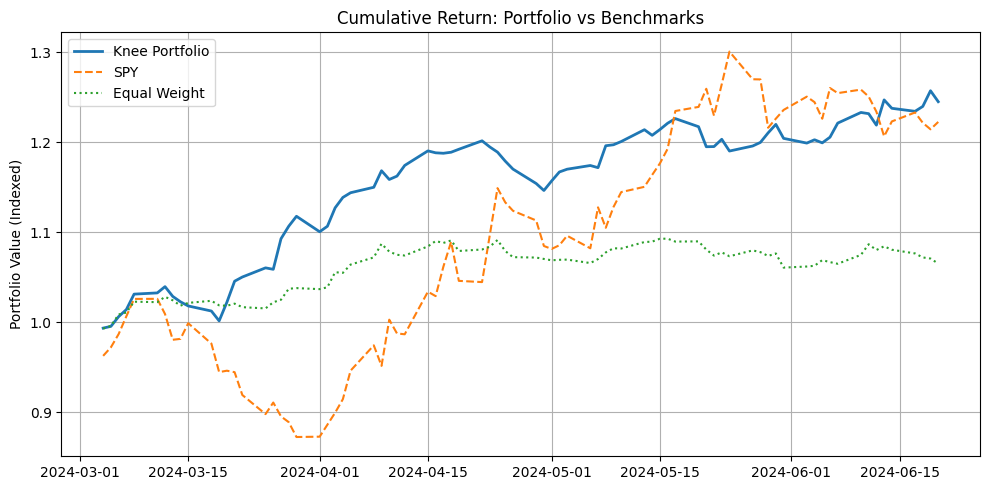

In [ ]:
# 📊 2. Benchmark Comparison
equal_weights = np.ones(len(target_tickers)) / len(target_tickers)
equal_returns = returns_df.dot(equal_weights)
equal_cumulative = (1 + equal_returns).cumprod()
knee_cumulative = (1 + knee_returns).cumprod()
spy_cumulative = (1 + spy_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(knee_cumulative, label="Knee Portfolio", linewidth=2)
plt.plot(spy_cumulative, label="SPY", linestyle='--')
plt.plot(equal_cumulative, label="Equal Weight", linestyle=':')
plt.title("Cumulative Return: Portfolio vs Benchmarks")
plt.ylabel("Portfolio Value (Indexed)")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# 📊 3. Diversification: Herfindahl-Hirschman Index (HHI)
knee_hhi = np.sum(knee_portfolio_weights ** 2)
print(f"📦 Diversification (HHI): {knee_hhi:.4f}")

📦 Diversification (HHI): 0.3660


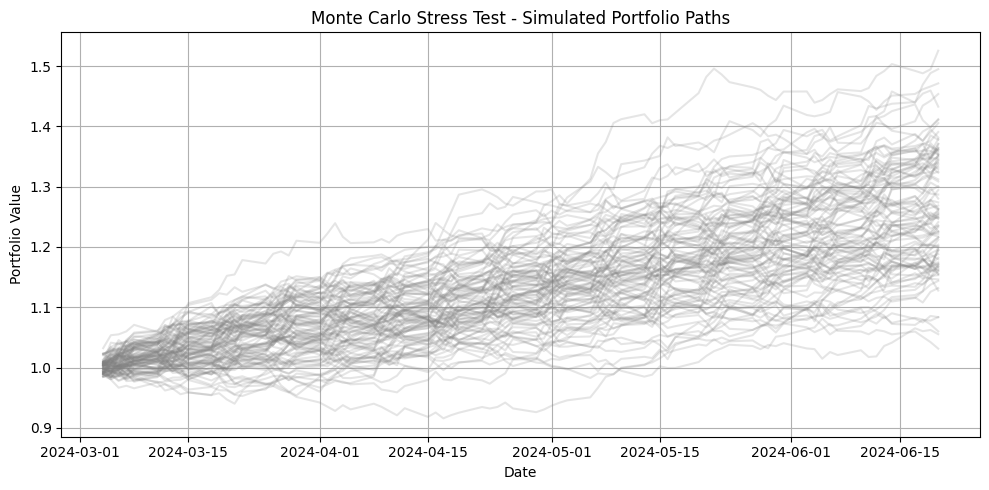

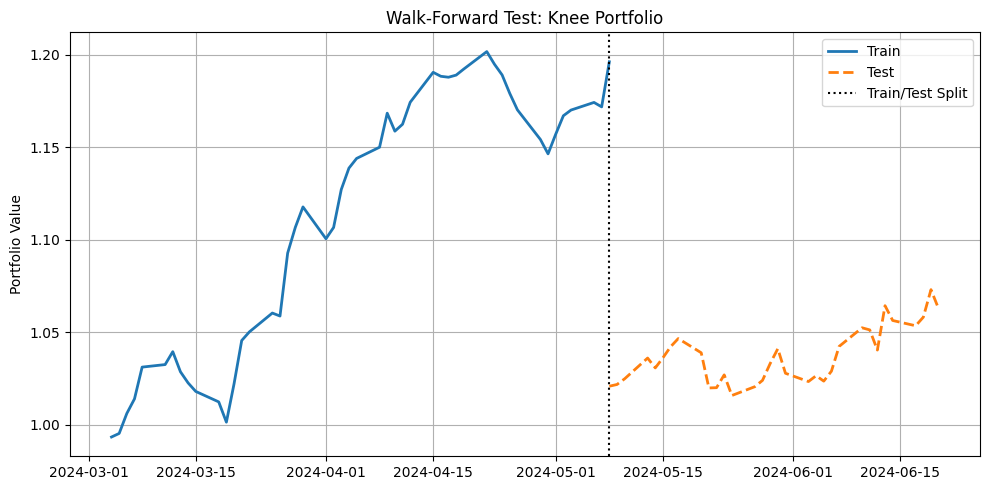

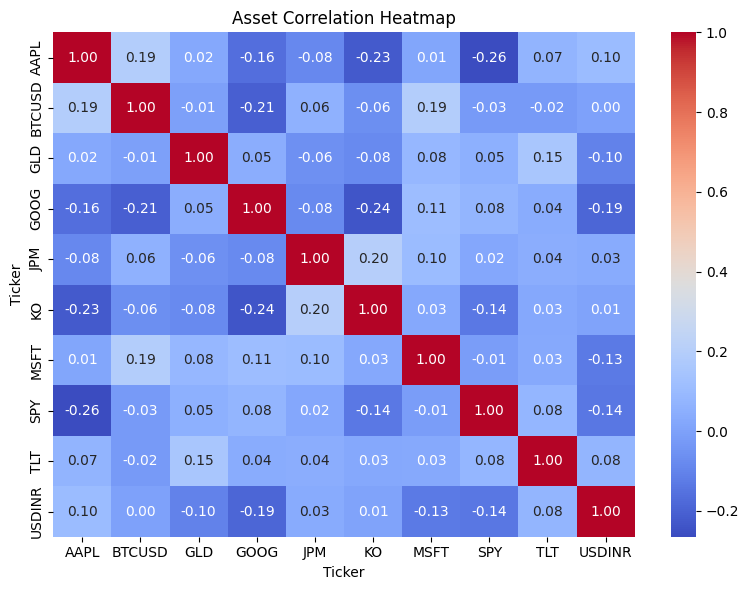

/tmp/ipython-input-29-2362893950.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


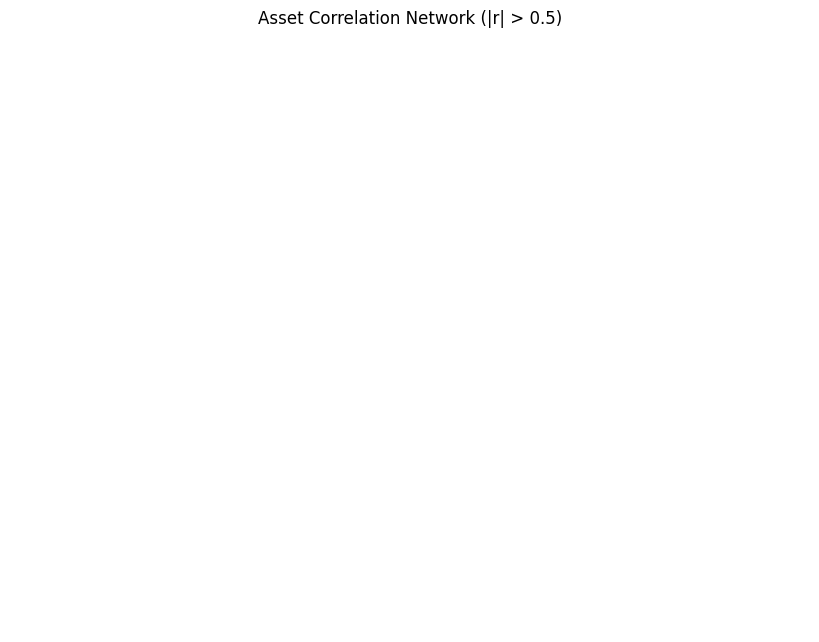

In [ ]:
# 🎲 4. Monte Carlo Stress Test (Bootstrap Simulation)
simulated_cum_returns = []
for _ in range(100):
    sampled_returns = knee_returns.sample(frac=1, replace=True)
    simulated_cumulative = (1 + sampled_returns).cumprod()
    simulated_cum_returns.append(simulated_cumulative.values)

plt.figure(figsize=(10, 5))
for sim in simulated_cum_returns:
    plt.plot(knee_returns.index, sim, alpha=0.2, color='gray')
plt.title("Monte Carlo Stress Test - Simulated Portfolio Paths")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.tight_layout()
plt.grid(True)
plt.show()

# 🔁 5. Walk-Forward Optimization (Train/Test Split)
split_point = int(len(returns_df) * 0.6)
split_date = returns_df.index[split_point]
train_returns = returns_df[:split_date]
test_returns = returns_df[split_date:]

train_perf = (1 + train_returns.dot(knee_portfolio_weights)).cumprod()
test_perf = (1 + test_returns.dot(knee_portfolio_weights)).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(train_perf, label="Train", linewidth=2)
plt.plot(test_perf, label="Test", linestyle='--', linewidth=2)
plt.axvline(x=split_date, color='black', linestyle=':', label="Train/Test Split")
plt.title("Walk-Forward Test: Knee Portfolio")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔗 6. Correlation Heatmap and Network Graph
corr_matrix = returns_df.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Asset Correlation Heatmap")
plt.tight_layout()
plt.show()

# Network Graph: show only strong correlations
threshold = 0.5
G = nx.Graph()
for i, asset_i in enumerate(corr_matrix.columns):
    for j, asset_j in enumerate(corr_matrix.columns):
        if i < j and abs(corr_matrix.iloc[i, j]) > threshold:
            G.add_edge(asset_i, asset_j, weight=corr_matrix.iloc[i, j])

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Asset Correlation Network (|r| > 0.5)")
plt.tight_layout()
plt.show()






#Chromosomes + Data Drift Code

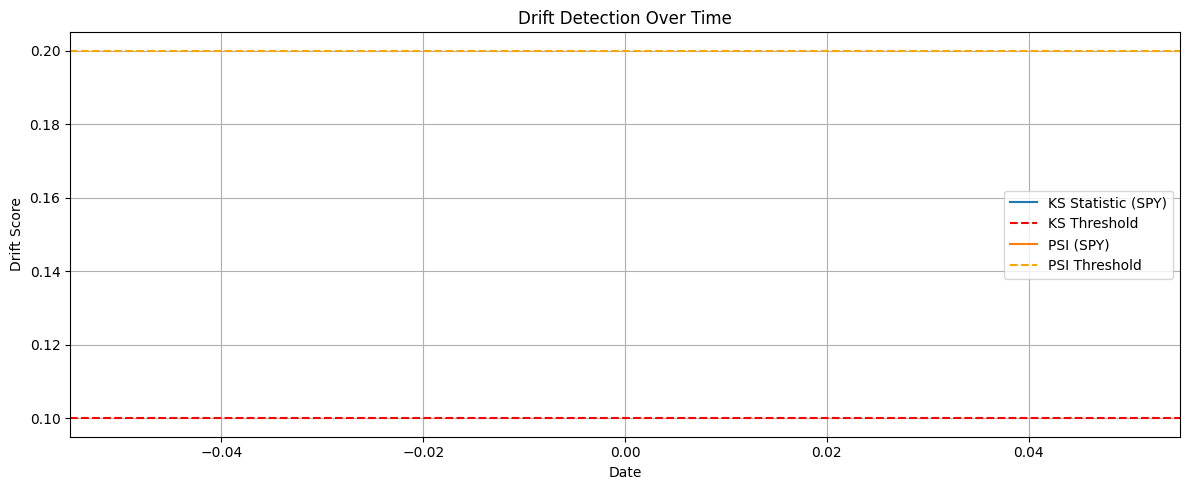

/tmp/ipython-input-30-3893279009.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


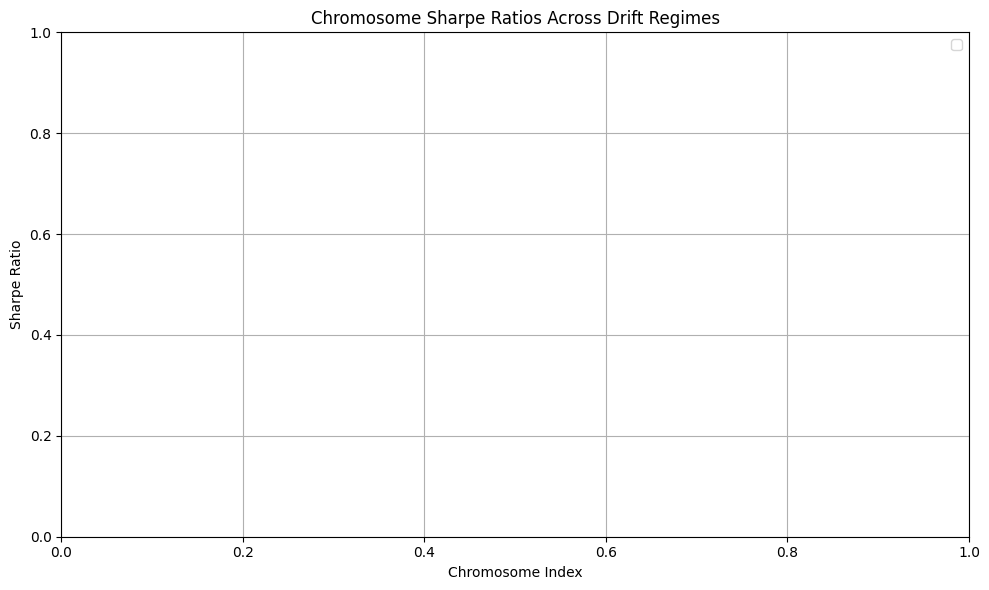

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns

# --- PARAMETERS ---
window_size = 120               # Lookback window (e.g., 6 months)
drift_threshold_ks = 0.1
drift_threshold_psi = 0.2
step = 10                       # Evaluation every 10 days
asset_to_monitor = 'SPY'        # Change this as needed

# --- HELPER FUNCTION: Population Stability Index ---
def calculate_psi(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    psi = np.sum((expected_percents - actual_percents) *
                 np.log((expected_percents + 1e-6) / (actual_percents + 1e-6)))
    return psi

# --- 1. DRIFT DETECTION ---
base_returns = returns_df.iloc[:window_size]
ks_results, psi_results, drift_dates = [], [], []
dates = []

for i in range(window_size, len(returns_df) - window_size, step):
    current_returns = returns_df.iloc[i:i+window_size]
    ks_stat, _ = ks_2samp(base_returns[asset_to_monitor], current_returns[asset_to_monitor])
    psi_val = calculate_psi(base_returns[asset_to_monitor], current_returns[asset_to_monitor])

    ks_results.append(ks_stat)
    psi_results.append(psi_val)
    current_date = returns_df.index[i]
    dates.append(current_date)

    # Identify drift points
    if ks_stat > drift_threshold_ks or psi_val > drift_threshold_psi:
        drift_dates.append(current_date)

# --- 2. PLOT DRIFT SCORES ---
plt.figure(figsize=(12, 5))
plt.plot(dates, ks_results, label=f"KS Statistic ({asset_to_monitor})")
plt.axhline(drift_threshold_ks, color='red', linestyle='--', label='KS Threshold')

plt.plot(dates, psi_results, label=f"PSI ({asset_to_monitor})")
plt.axhline(drift_threshold_psi, color='orange', linestyle='--', label='PSI Threshold')

plt.title("Drift Detection Over Time")
plt.ylabel("Drift Score")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. FITNESS EVALUATION AT DRIFT POINTS ---
regime_metrics = []

for d in drift_dates[:3]:  # Use first 3 drift regimes
    idx = returns_df.index.get_loc(d)
    regime_returns = returns_df.iloc[idx - window_size:idx]

    regime_sharpes = []
    for chromo in population:
        r = regime_returns.dot(chromo)
        sharpe = np.mean(r) / (np.std(r) + 1e-6)
        regime_sharpes.append(sharpe)

    regime_metrics.append(regime_sharpes)

# --- 4. PLOT CHROMOSOME STABILITY ---
plt.figure(figsize=(10, 6))
for i, scores in enumerate(regime_metrics):
    plt.plot(scores, label=f'Regime {i+1}', alpha=0.85)

plt.title("Chromosome Sharpe Ratios Across Drift Regimes")
plt.xlabel("Chromosome Index")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
